In [27]:
# Importamos las librerías necesarias para el desarrollo del modelo
import tensorflow as tf  # TensorFlow para trabajar con redes neuronales y modelos
import os  # Para la manipulación de rutas y directorios
from sklearn.neighbors import NearestNeighbors  # Para la implementación del índice k-NN
from matplotlib import pyplot as plt  # Para la visualización de imágenes
import pickle  # Para guardar y cargar el índice k-NN
from sklearn.metrics import precision_score, recall_score  # Para la evaluación del modelo
import numpy as np  # Para la manipulación de arrays
from PIL import Image  # Para cargar imágenes en formatos comunes

In [7]:
# Directorio principal de tu dataset
data_dir = 'D:\\U\\7. Septimo\\RI\\ir24a\\week14\\caltech-101'

In [8]:
# Función para cargar imágenes desde un directorio
def load_images(data_dir):
    images = []  # Lista para almacenar las imágenes
    labels = []  # Lista para almacenar las etiquetas (nombres de las clases)
    
    # Recorrer todas las subcarpetas (cada subcarpeta es una clase)
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        
        # Recorrer todas las imágenes en la subcarpeta
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            # Cargar la imagen y convertirla a un tensor
            image = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Ajusta el tamaño si es necesario
            image = tf.keras.preprocessing.image.img_to_array(image)  # Convertir la imagen a un array numpy
            images.append(image)  # Agregar la imagen a la lista
            labels.append(class_dir)  # Agregar la etiqueta a la lista
    
    # Convertir las listas a tensores de TensorFlow
    images = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)
    
    return images, labels

In [9]:
# Cargar las imágenes y etiquetas
images, labels = load_images(data_dir)
# Crear un dataset de TensorFlow a partir de las imágenes y etiquetas
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

In [10]:
# Dividir el dataset en entrenamiento y prueba (ajusta las proporciones según tus necesidades)
train_size = int(0.8 * len(images))  # El 80% de las imágenes para entrenamiento
test_size = len(images) - train_size  # El 20% restante para prueba
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [11]:
# Función para preprocesar las imágenes
def preprocess_image(image):
    image = tf.image.resize(image, [224, 224])  # Redimensionar la imagen a 224x224 píxeles
    image = image / 255.0  # Normalizar los valores de los píxeles a un rango de 0 a 1
    return image

In [12]:
# Función para preprocesar el dataset completo
def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (preprocess_image(x), y))

In [13]:
# Aplicar el preprocesamiento a los conjuntos de entrenamiento y prueba
train_dataset = preprocess_dataset(train_dataset)
test_dataset = preprocess_dataset(test_dataset)

# Crear lotes para el entrenamiento y la prueba
train_dataset = train_dataset.batch(32)  # Tamaño del lote de entrenamiento
test_dataset = test_dataset.batch(32)  # Tamaño del lote de prueba

In [14]:
# Cargar el modelo VGG16 preentrenado
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Crear un nuevo modelo que produzca los mapas de características
model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [15]:
# Función para extraer características de las imágenes utilizando el modelo
def extract_features(dataset, model):
    features = []  # Lista para almacenar las características
    for batch_images, _ in dataset:
        batch_features = model.predict(batch_images)  # Extraer características del lote de imágenes
        features.append(batch_features)  # Agregar las características a la lista
    return np.vstack(features)  # Apilar las características en un array numpy

In [16]:
# Extraer características de las imágenes de entrenamiento y prueba
train_features = extract_features(train_dataset, model)
test_features = extract_features(test_dataset, model)

58/58 [==============================] - 378s 6s/step


In [ ]:
# Aplanar las características para la búsqueda k-NN
train_features_flat = train_features.reshape(train_features.shape[0], -1)  # Convertir a un vector 1D
test_features_flat = test_features.reshape(test_features.shape[0], -1)  # Convertir a un vector 1D

In [53]:
# Crear el índice de k-NN con las características extraídas
knn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(train_features_flat)

In [54]:
# Función para encontrar imágenes similares utilizando el índice k-NN
def find_similar_images(query_features, knn_index, k=5):
    distances, indices = knn_index.kneighbors(query_features, n_neighbors=k)
    return indices, distances

In [55]:
# Guardar el índice k-NN en un archivo Pickle
with open('knn_index2.pkl', 'wb') as f:
    pickle.dump(knn, f)

Índice k-NN guardado en knn_index2.pkl


In [56]:
# Función para mostrar imágenes utilizando matplotlib
def show_images(images, titles=None):
    plt.figure(figsize=(15, 5))  # Crear una figura para las imágenes
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)  # Crear un subplot para cada imagen
        plt.imshow(image)  # Mostrar la imagen
        plt.axis('off')  # Ocultar los ejes
        if titles is not None:
            plt.title(titles[i])  # Mostrar título si se proporciona
    plt.show()

In [57]:
# Función para obtener una imagen del dataset dado su índice
def get_image_from_dataset(dataset, index):
    current_index = 0  # Contador para rastrear el índice actual
    for batch_images, batch_labels in dataset:
        for i in range(len(batch_images)):
            if current_index == index:
                return batch_images[i].numpy(), batch_labels[i].numpy()  # Retornar la imagen y la etiqueta si el índice coincide
            current_index += 1
    return None, None

In [58]:
# Función para buscar y mostrar imágenes similares
def search_and_display(query_image_index, test_dataset, train_dataset, knn_index, k=5):
    query_image, query_label = get_image_from_dataset(test_dataset, query_image_index)
    if query_image is None:
        print(f"Query image with index {query_image_index} not found.")
        return
    # Mostrar la imagen de consulta
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')
    plt.show()
    
    query_features = test_features_flat[query_image_index].reshape(1, -1)  # Extraer características de la imagen de consulta
    indices, distances = find_similar_images(query_features, knn_index, k)  # Encontrar imágenes similares
    
    similar_images = []  # Lista para almacenar las imágenes similares
    for idx in indices[0]:
        similar_image, _ = get_image_from_dataset(train_dataset, idx)  # Obtener la imagen similar del conjunto de entrenamiento
        if similar_image is not None:
            similar_images.append(similar_image)  # Agregar la imagen similar a la lista
    
    # Mostrar la imagen de consulta junto con las imágenes similares
    show_images([query_image] + similar_images, titles=["Query"] + [f"Similar {i+1}" for i in range(len(similar_images))])

In [67]:
# Función para cargar y probar una imagen independiente
def load_and_test_image(image_path, model, knn):
    image = Image.open(image_path)  # Abrir la imagen desde el archivo
    image = image.resize((224, 224))  # Redimensionar la imagen a 224x224 píxeles
    image = np.array(image) / 255.0  # Convertir la imagen a un array y normalizar los valores de los píxeles
    image = np.expand_dims(image, axis=0)  # Añadir una dimensión adicional
    
    # Extraer características de la imagen
    features = extract_features(tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(image), tf.convert_to_tensor([0]))), model)
    features_flat = features.reshape(features.shape[0], -1)  # Aplanar las características
    
    # Encontrar imágenes similares utilizando el índice k-NN
    indices, distances = find_similar_images(features_flat, knn)
    
    similar_images = []  # Lista para almacenar las imágenes similares
    for idx in indices[0]:
        similar_image, _ = get_image_from_dataset(train_dataset, idx)  # Obtener la imagen similar del conjunto de entrenamiento
        if similar_image is not None:
            similar_images.append(similar_image)  # Agregar la imagen similar a la lista
    
    # Mostrar la imagen cargada junto con las imágenes similares
    show_images([image[0]] + similar_images, titles=["Uploaded"] + [f"Similar {i+1}" for i in range(len(similar_images))])

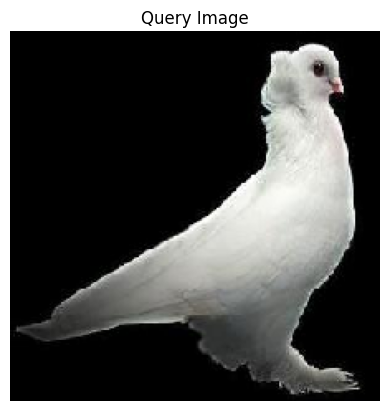

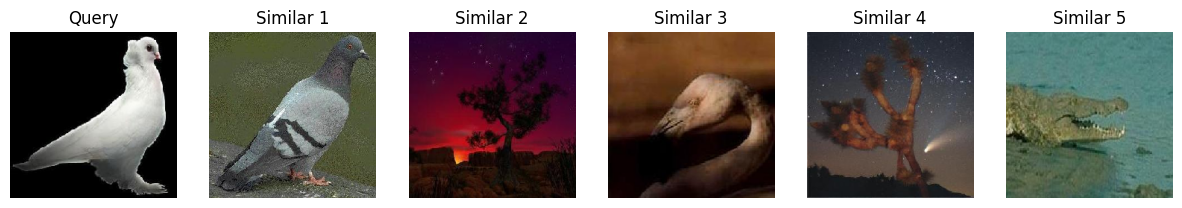

In [68]:
# Ejemplo de uso: buscar imágenes similares a la imagen con índice 0 del conjunto de prueba
search_and_display(0, test_dataset, train_dataset, knn)

In [69]:
# Cargar el índice k-NN guardado desde un archivo Pickle
# Esto nos permite reutilizar el índice k-NN previamente entrenado sin tener que volver a entrenarlo
with open('knn_index2.pkl', 'rb') as f:
    knn = pickle.load(f)  # Cargar el índice k-NN desde el archivo

In [1]:
# Función para evaluar el sistema de búsqueda basado en imágenes
def evaluate_system(test_features, test_labels, train_labels, knn_index):
    y_true = []  # Lista para almacenar las etiquetas verdaderas de las imágenes de prueba
    y_pred = []  # Lista para almacenar las etiquetas predichas por el modelo
    
    # Aplanar las características de prueba para la búsqueda k-NN
    test_features_flat = test_features.reshape(test_features.shape[0], -1)
    
    # Iterar sobre todas las imágenes de prueba
    for i in range(len(test_features)):
        # Extraer las características de la imagen de prueba actual
        query_features = test_features_flat[i].reshape(1, -1)
        
        # Buscar la imagen más cercana en el índice k-NN
        distances, indices = knn_index.kneighbors(query_features, n_neighbors=1)
        
        # Agregar la etiqueta verdadera de la imagen de prueba
        y_true.append(test_labels[i])
        
        # Agregar la etiqueta de la imagen más cercana del conjunto de entrenamiento como la predicción
        y_pred.append(train_labels[indices[0][0]])
    
    # Calcular la precisión del sistema
    # 'macro' significa que se calculan las métricas para cada clase y luego se promedian
    # 'zero_division=1' asegura que no haya error si una clase no está presente en la predicción
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    
    # Calcular el recall del sistema
    # 'macro' significa que se calculan las métricas para cada clase y luego se promedian
    recall = recall_score(y_true, y_pred, average='macro')
    
    return precision, recall  # Retornar las métricas de precisión y recall

In [71]:
# Evaluar el sistema utilizando las características de prueba y las etiquetas
# Convertir las etiquetas de prueba de TensorFlow a numpy si es necesario
# Configuración 1: k=5
knn1 = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(train_features_flat)
precision1, recall1, f1_1 = evaluate_system(test_features, labels.numpy(), train_labels, knn1)
print(f"Config 1 - Precision: {precision1}, Recall: {recall1}, F1-score: {f1_1}")

# Configuración 2: k=10
knn2 = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(train_features_flat)
precision2, recall2, f1_2 = evaluate_system(test_features, labels.numpy(), train_labels, knn2)
print(f"Config 2 - Precision: {precision2}, Recall: {recall2}, F1-score: {f1_2}")

Precision: 0.05605189588565548, Recall: 0.0035195832458733626


d:\U\7. Septimo\RI\Proyecto-IIB-RI\proy\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
# Guardar el modelo utilizado para la extracción de características en un archivo .h5
model.save('modelo2.h5')

d:\U\7. Septimo\RI\Proyecto-IIB-RI\proy\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
